In [23]:
import torch
import numpy as np
from drlqap.qap import GraphAssignmentProblem
from drlqap import dqn_nets, reinforce_nets, taskgenerators
from drlqap.simplesolver import solve_qap_backtracking
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from numpy.lib.stride_tricks import sliding_window_view

In [27]:
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

# Setup

In [2]:
with open("../qapdata/testgraph.dat", "r") as f:
    qap = GraphAssignmentProblem.from_qaplib_string(f.read())

nets = {
    "dqn.mp_gat": lambda: dqn_nets.mp_gat(32, 32, 32, 3), 
    "dqn.mp_gat_no_lp": lambda: dqn_nets.mp_gat_no_lp(64, 64, 64, 3), 
    "dqn.simple_link_prediction": lambda: dqn_nets.simple_link_prediction_undirected(32, 32, 3),
    "dqn.mp_histogram_gat": lambda: dqn_nets.mp_histogram_gat(32, 32, 3),
}

# Target matrix

In [3]:
optimal_value, optimal_assignment = solve_qap_backtracking(qap)

In [4]:
optimal_assignment

[7, 6, 4, 0, 2, 3, 1, 5]

In [5]:
optimal_matrix = torch.eye(qap.size)[optimal_assignment]


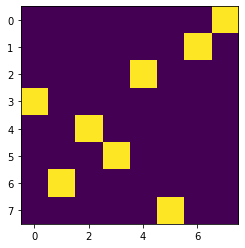

In [6]:
plt.imshow(optimal_matrix)

# Initial output

In [7]:
def show_output(net):
    net_output = net(qap)
    plt.imshow(net_output.detach())

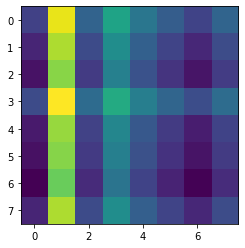

In [8]:
show_output(nets["dqn.mp_gat"]())

# Train

In [9]:
def train(net, epochs):
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)   
    losses = []
    for i in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        net_output = net(qap)
        loss = torch.nn.functional.mse_loss(net_output.flatten(), optimal_matrix.flatten())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [10]:
results = {}

In [11]:
repetitions = 2
for name, net_constructor in nets.items():
    current_results = results[name] if name in results else []
    for i in range(len(current_results), repetitions):
        net = net_constructor()
        losses = train(net, 400)
        print(f"{name} final loss: {losses[-1]}")
        current_results.append((net, losses))
    results[name] = current_results

print("done")

dqn.mp_gat final loss: 0.1093750074505806
dqn.mp_gat final loss: 0.10938020050525665
dqn.mp_gat_no_lp final loss: 0.10940548032522202
dqn.mp_gat_no_lp final loss: 0.1136152520775795
dqn.simple_link_prediction final loss: 1.4516039481549114e-09
dqn.simple_link_prediction final loss: 0.0002148861822206527
dqn.mp_histogram_gat final loss: 9.75365037447773e-06
dqn.mp_histogram_gat final loss: 4.984330735169351e-05
done



# Loss curves

In [43]:
from bokeh.palettes import Dark2_5 
from bokeh.models import Range1d

fig = figure()

def moving_average(x, n=3) :
    return np.mean(sliding_window_view(x, window_shape=n), axis=-1)

for i, (name, net_runs) in enumerate(results.items()):
    #for net, loss in net_runs:
    #    plt.plot(loss, label=name)
    average_loss = np.mean([run[1] for run in net_runs], axis=0)
    fig.line(x=range(len(average_loss)), y=average_loss, legend_label=name, color=Dark2_5[i])

fig.y_range = Range1d(0,0.2)
fig.legend.click_policy = "hide"
show(fig)

# Outputs

In [59]:
fig = figure()
net_output = net(qap)
fig.image(image=[net_output.detach().numpy()], x=0, y=0, dw=qap.size, dh=qap.size)
show(fig)